# 4. Bayesian computing

This notebook will cover important [`R`](https://www.r-project.org/) commands highlighted in Ch. 4 of the textbook, *Spatial and Spatio-temporal Bayesian Models with R-INLA* by Blangiardo and Cameletti.

## 4.4. Monte Carlo simulations

### Approximating the rate parameter

Let's imagine a stochastic process that occurs (i.e., succeeds) at an unknown rate $\lambda$ [1/s]. We collect data by considering $n$ successes and computing the time interval between them (starting from $t=0$). We can simulate this by sampling from the probabilistic model, called the **likelihood** $\rho(\mathcal{D} \vert \theta)$, where we model the wait time interval data as a r.v.

$$
Y \sim \text{Exponential}(\lambda).
$$

Let $\mathbf{y} := (y_i)_{i=1}^n$, where each $y_i$ is an i.i.d. realization of $Y$. Setting $n := 50$ and $\lambda := 2$, we simulate the data using `R`'s [`rexp`](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Exponential.html) function.

In [1]:
set.seed(1)
n <- 50
lambda <- 2
y <- rexp(n, lambda)
print(y)

 [1] 0.37759092 0.59082139 0.07285336 0.06989763 0.21803431 1.44748427
 [7] 0.61478103 0.26984142 0.47828375 0.07352300 0.69536756 0.38101493
[13] 0.61880178 2.21196711 0.52727158 0.51762197 0.93801759 0.32737332
[19] 0.16846674 0.29423986 1.18225763 0.32094629 0.14706019 0.28293276
[25] 0.05303631 0.02971958 0.28935623 1.97946643 0.58665605 0.49840648
[31] 0.71764267 0.01863426 0.16200508 0.66023396 0.10175518 0.51136294
[37] 0.15087047 0.36260715 0.37577135 0.11751373 0.53994057 0.51412345
[43] 0.64613082 0.62655268 0.27732070 0.15064150 0.64656233 0.49727789
[49] 0.25708715 1.00391620


Our job now is to take the data $\mathbf{y}$ and reverse-engineer the true rate $\lambda$ from it (hopefully we get something close to 2!).

We first need a guess for the rate parameter; in fact, we'll define an entire "guess distribution" for $\lambda$, called the **prior** $\rho(\theta)$, where we assume this nonnegative temporal rate is an instance of a r.v.

$$
\Lambda \sim \text{Gamma}(a,b).
$$

We will set the prior **hyperparameters** $a := 8$ and $b := 4$.

In [2]:
a <- 8
b <- 4

The resulting **posterior** $\rho(\theta \vert \mathcal{D}) \propto \rho(\mathcal{D} \vert \theta)\rho(\theta)$ is **conjugate** to the prior, i.e., the prior-likelihood pair produces a posterior from the same family of distributions as the prior. In this example,

$$
\Lambda \vert \mathbf{Y}=\mathbf{y} \sim \text{Gamma}(a_1,b_1),
$$

where $a_1 := a+n$ and $b_1 := b+n\bar y$ (here $\bar y$ denotes the data mean).

In [3]:
a1 <- a + n
b1 <- b + n*mean(y)

---

#### An aside: Posterior derivation

If it's hard to convince yourself that the resulting posterior distribution, in this case, is indeed another gamma distribution, we will derive this fact here. First we consider the exponential likelihood for *one observation* with its density's functional form

$$
\rho(y \vert \lambda) = \lambda e^{-\lambda y}.
$$

Similarly, the prior PDF is

$$
\rho(\lambda) \propto \lambda^{a-1}e^{-b\lambda}.
$$

The resulting posterior PDF from the product of the two is, then,

$$
\rho(\lambda \vert y) \propto \lambda^{(a+1)-1}e^{-(b+y)\lambda},
$$

that is, $\Lambda \vert Y=y \sim \text{Gamma}(a+1,b+y)$.

Next, let's consider the case with $n$ observations. Since we assume that they are i.i.d., the likelihood is the product

$$
\rho(\mathbf{y}) = \prod_{i=1}^n \rho(y_i) = \lambda^n \prod_{i=1}^n e^{-\lambda y_i} = \lambda^n e^{-\lambda \sum_{i=1}^n y_i},
$$

and the resulting posterior is

$$
\rho(\lambda \vert \mathbf{y}) \propto \lambda^{(a+n)-1}e^{-(b+\sum_{i=1}^n y_i)\lambda}.
$$

Noting the equivalence $\sum_{i=1}^n y_i = n\bar y$ from the definition of sample mean, we arrive at the posterior distribution above:

$$
\Lambda \vert \mathbf{Y}=\mathbf{y} \sim \text{Gamma}(a+n,b+n\bar y).
$$

---

Given this posterior, we can now answer the question of, "What is the rate parameter given the data (and prior assumptions)?". One such answer is to take the expected value of the posterior distribution, that is, $\hat\lambda := \mathbb{E}[\Lambda \vert \mathbf{Y}=\mathbf{y}]$. In this particular case, there is an analytical form of $\hat\lambda$, namely, $\frac{a_1}{b_1} = \frac{a+n}{b+n\bar y}$.

In [4]:
lambdahat <- a1/b1
print(lambdahat)

[1] 2.027898


However, an alternate answer to our question could have been the median of the posterior. Even in the case with a well-known (gamma) distribution, there is no analytical form for the median and it must be approximated asymptotically/computationally. We can even anticipate more difficult cases where not even an asymptotic form exists; how, then, should we go around this problem? One answer is with **Monte Carlo (MC) simulations**.

Let's continue with the expected value example. We want to simulate samples of $\lambda$ from the posterior gamma distribution. We will set the number of samples as $m := 1000$ and use `R`'s [`rgamma`](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/GammaDist.html) function. Finally, we take the sample mean to get the simulated estimate $\bar\lambda$.

In [5]:
set.seed(2)
m <- 1000
lambdas <- rgamma(n=m, shape=a1, rate=b1)
lambdabar <- mean(lambdas)
print(lambdabar)

[1] 2.040972


The sample mean $\bar\lambda \approx 2.040972$ is not too far off from the theoretical mean $\hat\lambda \approx 2.027898$, which is not a bad estimate of the unknown, data-generating rate $\lambda = 2$.

Let's visualize the entire posterior distribution $\rho(\lambda \vert \mathbf{y})$ (histogram of the simulations and theoretical density in black) and the expected value (solid vertical line for $\hat\lambda$ and dashed for $\bar\lambda$ in red):

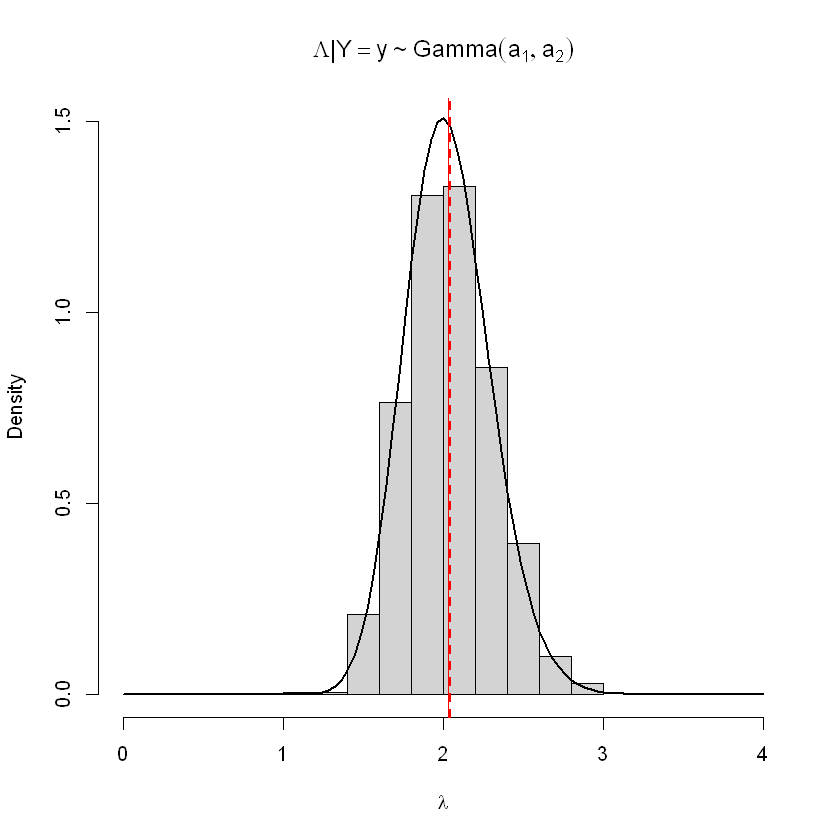

In [6]:
hist(lambdas, freq=F, xlim=c(0,4), ylim=c(0,1.5), xlab=expression(lambda),
     main=expression(Lambda *"|"* Y==y %~% textstyle("Gamma")(a[1],a[2])))
curve(dgamma(x, a1, rate=b1), from=0, to=4, lwd=2, add=T)
abline(v=lambdahat, col="red")
abline(v=lambdabar, col="red", lwd=2, lty=2)

#### Effect of simulation size

We had somewhat arbitrarily set the simulation size at $m := 1000$. However, we would expect the sample mean $\bar\lambda$ to "converge" to the theoretical mean $\hat\lambda$ as we increase $m$. Furthermore, how *quickly* these means converge can be captured by the standard error of the sample mean estimate

$$
\text{SE}(\bar\lambda) = \sqrt{\frac{s^2}{m}} = \sqrt{\frac{\frac{1}{m}\sum_{j=1}^m (\lambda_j-\bar\lambda)^2}{m}} \approx \sqrt{\frac{\text{Var}(\Lambda\vert\mathbf{Y}=\mathbf{y})}{m}},
$$

where $s^2$ is the sample variance of the $m$ simulated $\lambda_j$s from the posterior distribution. Note the effective use of the [`set.seed`](https://stat.ethz.ch/R-manual/R-devel/library/base/html/Random.html) function *inside* the `for` loop so we can track the evolution of the rate estimate as a running average, as well as the upper ($u := \bar\lambda+1.96\text{SE}(\bar\lambda)$) and lower ($l := \bar\lambda-1.96\text{SE}(\bar\lambda)$) 95% confidence bounds.

In [7]:
set.seed(3)
N <- 5000
M <- 1
ms <- integer(N)
lambdabars <- numeric(N)
ses <- numeric(N)
lambdas <- NULL
for (i in 1:N) {
    ms[i] <- M*i
    lambdas <- append(lambdas, rgamma(n=M, shape=a1, rate=b1))
    lambdabars[i] <- mean(lambdas)
    ses[i] <- sqrt(var(lambdas)/ms[i])
}
us <- lambdabars + 1.96*ses
ls <- lambdabars - 1.96*ses

Visualizing the sample means (black) and confidence bounds (grey), as well as the true rate $\lambda$ (solid) and the theoretical posterior mean $\hat\lambda$ (dashed) in red, we can see the running average tending towards the theoretical mean on the order of $\text{SE}(\bar\lambda) \sim 1/\sqrt{m}$.

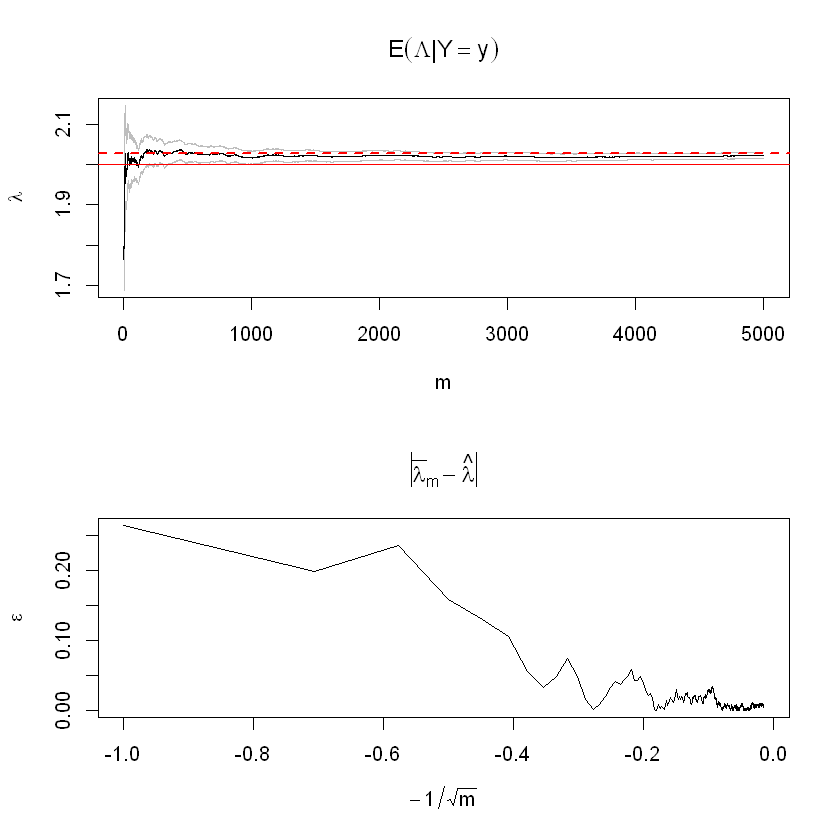

In [8]:
par(mfrow=c(2,1))
plot(ms, us, col="grey", xlab="m", ylab=expression(lambda),
     main=expression("E"(Lambda *"|"* Y==y)),
     ylim=c(min(ls, na.rm=T), max(us, na.rm=T)), type="l")
lines(ms, ls, col="grey")
lines(ms, lambdabars)
abline(h=lambda, col="red")
abline(h=lambdahat, col="red", lwd=2, lty=2)
plot(-1/sqrt(ms), abs(lambdabars-lambdahat), type="l",
     xlab=expression(-1/sqrt(m)), ylab=expression(epsilon),
     main=expression(abs(bar(lambda)[m] - hat(lambda))))

### Approximating a generic observable

The next example we will consider deals with using MC simulations to estimate a statistic derived from a model parameter. To make things more concrete, let's imagine $n$ random events, each with an unknown probability $p$ of success. This can data-generating process can be modeled as a r.v.

$$
Y \sim \text{Binomial}(n,p).
$$

We will set $n := 1000$ and $p := 0.8$, leading to the single data point $y$.

In [9]:
set.seed(4)
n <- 1000
p <- 0.8
y <- rbinom(n=1, size=n, p=p)
print(y)

[1] 778


Our goal here is to not only estimate the parameter $p$ from the above datum, but also its derived statistic (commonly used in epidemiology), the **log-odds**, defined as

$$
h(p) := \log\left(\frac{p}{1-p}\right).
$$

As in the previous section, we first need an assumption on the probability $p$, which takes a value between 0 and 1. We will assume the prior distribution

$$
P \sim \text{Beta}(a,b),
$$

with $a := 1$ and $b := 1$.

In [10]:
a <- 1
b <- 1

The beta prior is conjugate to its posterior under a binomial likelihood, so the parameter given the data is distributed as

$$
P \vert Y=y \sim \text{Beta}(a_1,b_1),
$$

where $a_1 := y+a$ and $b_1 := n-y+b$ (we will not derive this here).

In [11]:
a1 <- y + a
b1 <- n-y + b

We may want to compute, for instance, the expected value of the log-odds from the data:

$$
H := \mathbb{E}[h(P) \vert Y=y] = \int_0^1 \log\left(\frac{p}{1-p}\right) \underbrace{\overbrace{\frac{\Gamma(a_1+b_1)}{\Gamma(a_1)\Gamma(b_1)}}^{\Beta(a_1,b_1)^{-1}}p^{a_1-1}(1-p)^{b_1-1}}_{\rho(p \vert y)}\, \text{d}p,
$$

where we have substituted in the functional form of the posterior beta PDF. Unlike with the vanilla expected value of $P \vert Y=y$, $H$ does not have a closed form solution (try to find one, if you don't believe it!). But estimating it with MC simulations is trivial:

$$
\hat H := \frac{1}{m} \sum_{j=1}^m \log\left(\frac{p_j}{1-p_j}\right),
$$

with each $p_j$ sampled i.i.d. from the *posterior* distribution.

In [12]:
set.seed(5)
m <- 50000
ps <- rbeta(n=m, shape1=a1, shape2=b1)
hps <- log(ps/(1-ps))
Hhat <- mean(hps)
print(Hhat)

[1] 1.253019


While there isn't an analytical form of $H$, `R` provides an [`integrate`](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/integrate.html) function to numerically integrate a custom integrand (using a quadrature method). 

In [13]:
hrho <- function(p,a,b) {
    log(p/(1-p)) * p^(a-1)*(1-p)^(b-1)/beta(a,b)
}
H <- integrate(hrho, lower=0, upper=1, a=a1, b=b1)$value
print(H)

[1] 1.252441


We can see from the above two cells that the MC approximation with $m$ samples ($\hat H \approx 1.253019$) comes pretty close to the numerical average ($H \approx 1.252441$).

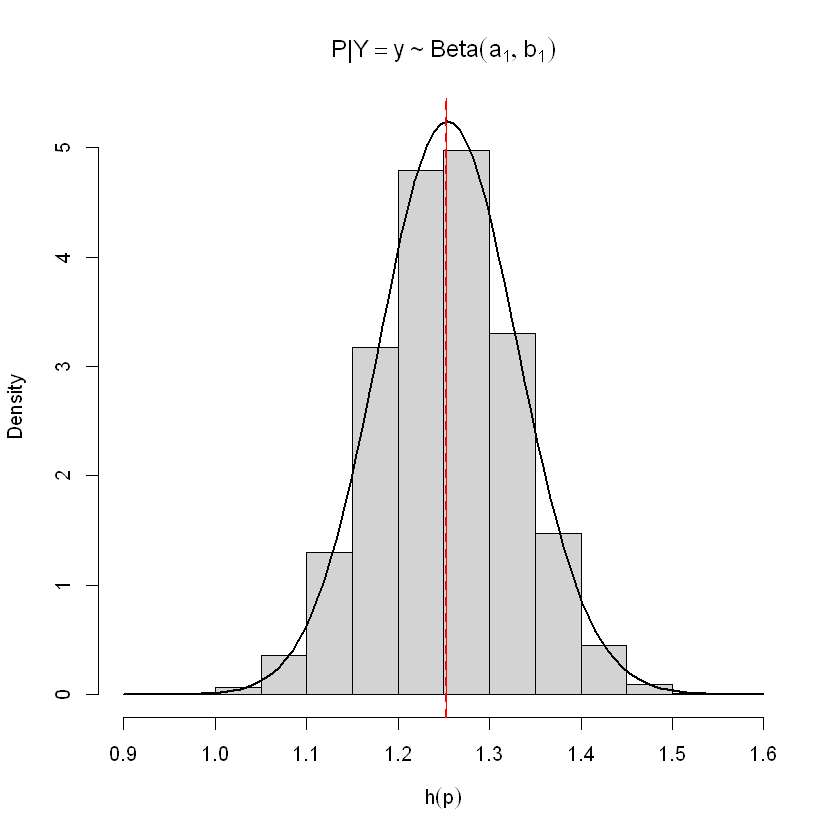

In [14]:
h0 <- 0.9
hf <- 1.6
nh <- 100
dh <- (hf - h0)/(nh - 1)
hP <- seq(h0, hf, length=nh)
P <- exp(hP)/(exp(hP) + 1)
rhoP <- dbeta(P, shape1=a1, shape2=b1)
rhoP <- rhoP/(sum(rhoP)*dh)
hist(hps, freq=F, xlab=expression(h(p)), ylim=c(0,max(rhoP)),
     main=expression(P *"|"* Y==y %~% textstyle("Beta")(a[1],b[1])))
lines(hP, rhoP, lwd=2)
abline(v=H, col="red")
abline(v=Hhat, col="red", lwd=2, lty=2)

As in the previous section, we can (effectively) run the simulation multiple times from a small $m$ to a large one to get a running MC average:

In [15]:
set.seed(6)
N <- 10000
M <- 5
ms <- integer(N)
Hhats <- numeric(N)
ses <- numeric(N)
ps <- NULL
hps <- NULL
for (i in 1:N) {
    ms[i] <- M*i
    q <- rbeta(n=M, shape1=a1, shape2=b1)
    ps <- append(ps, q)
    hps <- append(hps, log(q/(1-q)))
    Hhats[i] <- mean(hps)
    ses[i] <- sqrt(var(hps)/ms[i])
}
us <- Hhats + 1.96*ses
ls <- Hhats - 1.96*ses

Finally, let's visualize the convergence of $\hat H$ to $H$ with respect to $m$.

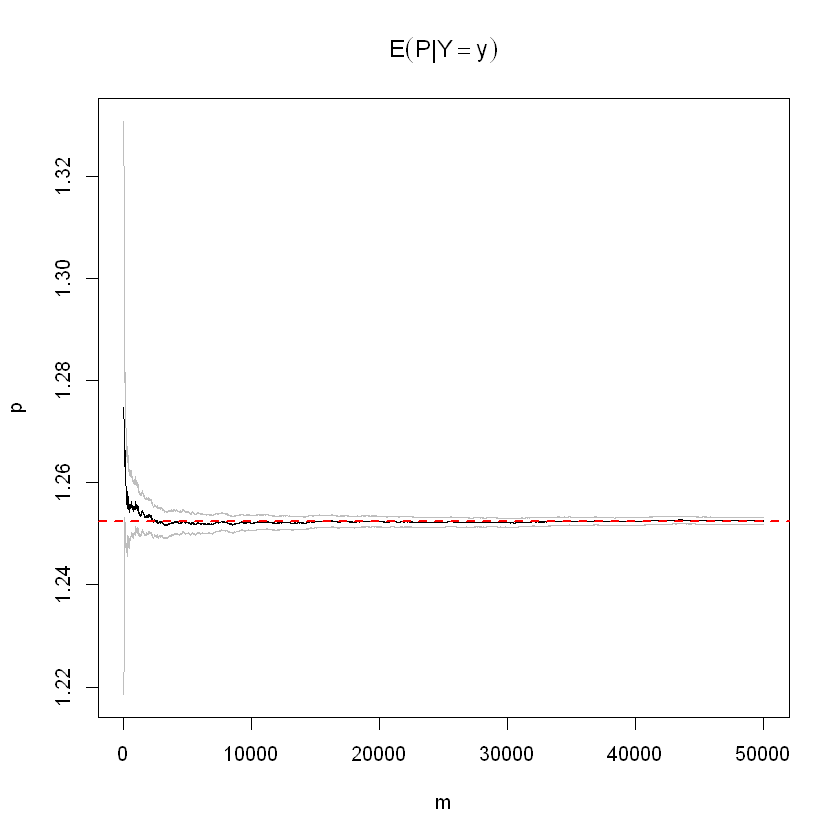

In [16]:
plot(ms, us, col="grey", xlab="m", ylab="p",
     main=expression("E"(P *"|"* Y==y)),
     ylim=c(min(ls, na.rm=T), max(us, na.rm=T)), type="l")
lines(ms, ls, col="grey")
lines(ms, Hhats)
abline(h=H, col="red", lwd=2, lty=2)